In [1]:
!pip install optuna
!pip install catboost



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# EDA for
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import optuna
import gc

# Metrics
from sklearn.metrics import (
    mean_squared_error
)

from tensorflow.keras.metrics import RootMeanSquaredError

# Models
from sklearn.linear_model import LinearRegression
import keras_tuner
from keras import *
from keras import Sequential

from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import (
    train_test_split,
    KFold,
)

from sklearn.preprocessing import RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

from catboost import *

# Any
import warnings
warnings.filterwarnings('ignore')

In [4]:
class CFG:
        TARGET = ['nivel_y']
        # FEATURES = ['center_bubbles_px','temperature','1','2','99','100', 'median','mean', 'std','max','min','length']
        N_FOLDS = 20
        RANDOM_STATE = 87
        def dataset() -> pd.DataFrame:
            TRAIN_PATH = './data/Drift/2024_08_10 16_20_01.csv'
            TEST_PATH_1 = './test/Drift/test1.csv'
            TEST_PATH_2 = './test/Drift/test2.csv'
            TEST_PATH_3 = './test/Drift/test3.csv'
            TEST_PATH_4 = './test/Drift/test4.csv'

            train = pd.read_csv(TRAIN_PATH)[200:]
            test_1 = pd.concat([pd.read_csv(TEST_PATH_1)[200:],pd.read_csv(TEST_PATH_2)], ignore_index=True)
            test_2 = pd.read_csv(TEST_PATH_3)
            test_3 = pd.read_csv(TEST_PATH_4)[600:]

            return train, test_1, test_2, test_3

In [5]:
train, test_1, test_2, test_3 = CFG.dataset()

<Axes: >

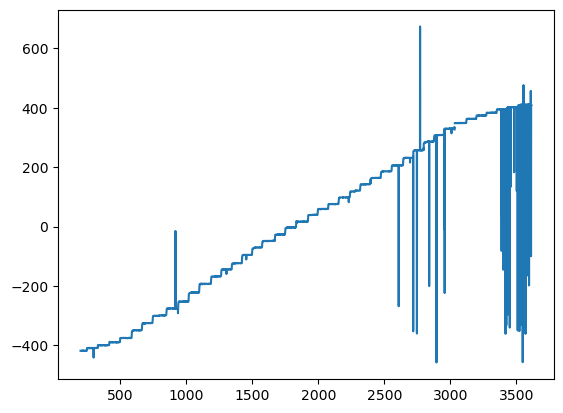

In [6]:
train['center_bubbles_px'].plot()

<Axes: >

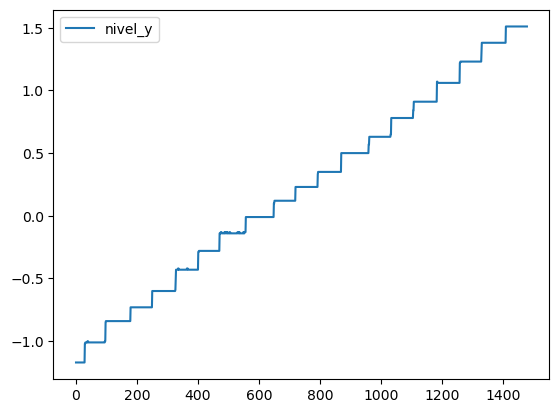

In [7]:
test_1[CFG.TARGET].plot()

<Axes: >

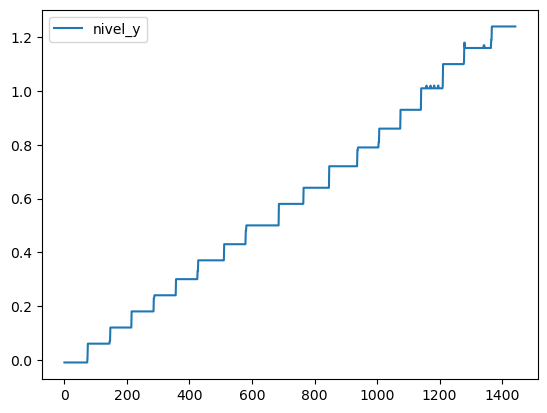

In [8]:
test_2[CFG.TARGET].plot()

<Axes: >

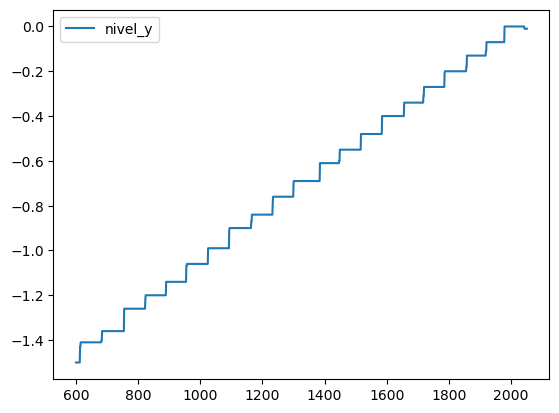

In [9]:
test_3[CFG.TARGET].plot()

In [10]:
train = train.loc[train['watch_indicator'] == 'recording']
train = train.drop(columns=['time', 'watch_indicator', 'nivel_x', 'nivel_t'])

test_1 = test_1.loc[test_1['watch_indicator'] == 'recording']
test_1 = test_1.drop(columns=['time', 'watch_indicator', 'nivel_x', 'nivel_t'])

test_2 = test_2.loc[test_2['watch_indicator'] == 'recording']
test_2 = test_2.drop(columns=['time', 'watch_indicator', 'nivel_x', 'nivel_t'])

test_3 = test_3.loc[test_3['watch_indicator'] == 'recording']
test_3 = test_3.drop(columns=['time', 'watch_indicator', 'nivel_x', 'nivel_t'])


In [11]:
def agg_features(df, suffix=''):
    X = pd.DataFrame()    
    X[suffix+"median"] = df.median(axis=1)
    X[suffix+"mean"] = df.mean(axis=1)
    X[suffix+"std"] = df.std(axis=1)
    X[suffix+"max"] = df.max(axis=1)
    X[suffix+"min"] = df.min(axis=1)
    for i in range(3,99,2):
        X[str(i)+"length"] = np.sqrt((df['1']-df[str(i)])**2 + (df['2']-df[str(i+1)])**2)
    return X

In [12]:
train = train.astype(float)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2912 entries, 200 to 3601
Columns: 103 entries, center_bubbles_px to 100
dtypes: float64(103)
memory usage: 2.3 MB


In [14]:
train = train.join(agg_features(train), how='left')
test_1 = test_1.join(agg_features(test_1), how='left')
test_2 = test_2.join(agg_features(test_2), how='left')
test_3 = test_3.join(agg_features(test_3), how='left')

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2912 entries, 200 to 3601
Columns: 156 entries, center_bubbles_px to 97length
dtypes: float64(156)
memory usage: 3.5 MB


In [16]:
train.dropna(inplace=True)
test_1.dropna(inplace=True)
test_2.dropna(inplace=True)
test_3.dropna(inplace=True)
train = train.reset_index(drop=True)
test_1 = test_1.reset_index(drop=True)
test_2 = test_2.reset_index(drop=True)
test_3 = test_3.reset_index(drop=True)


for i in train.columns:
    if i not in [CFG.TARGET]:
        train[i] = train[i].interpolate(method='nearest', limit_direction='forward')
        test_1[i] = test_1[i].interpolate(method='nearest', limit_direction='forward')
        test_2[i] = test_2[i].interpolate(method='nearest', limit_direction='forward')
        test_3[i] = test_3[i].interpolate(method='nearest', limit_direction='forward')

<Axes: >

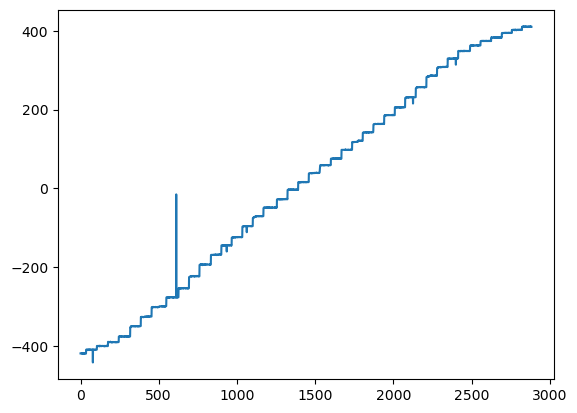

In [17]:
train['center_bubbles_px'].plot()

In [18]:
temp = pd.concat([train['center_bubbles_px'], train[CFG.TARGET]])

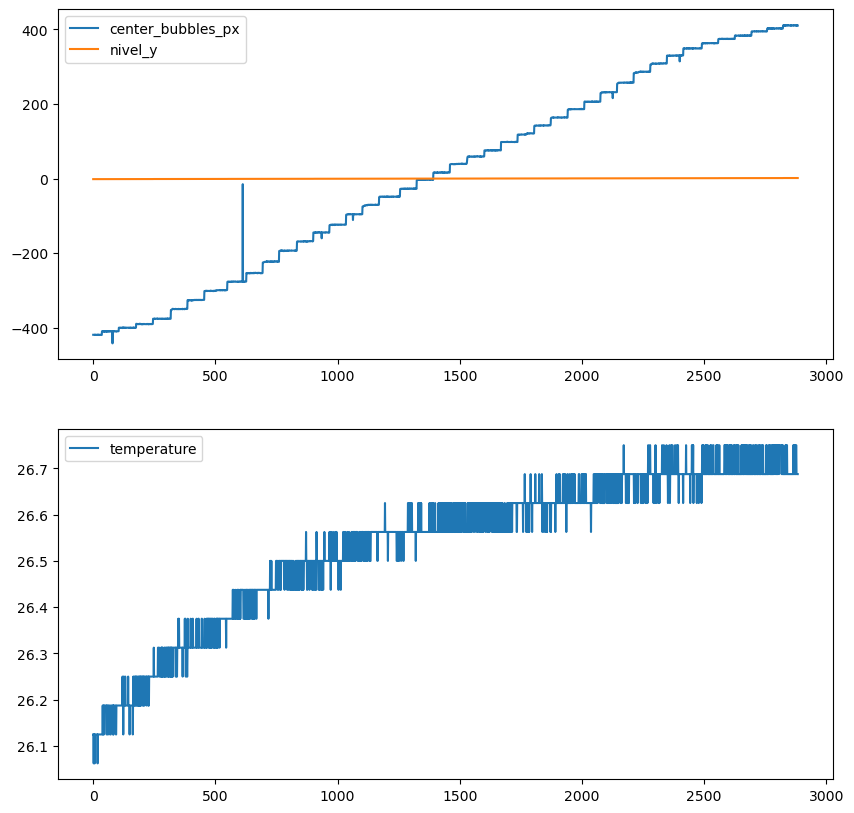

In [19]:
fig = plt.figure(figsize=(10,10))
ax1 =fig.add_subplot(2,1,1)
temp.plot(ax = ax1)
ax2 =fig.add_subplot(2,1,2)
train['temperature'].plot(ax = ax2, legend='temperature')
plt.show()

<Axes: >

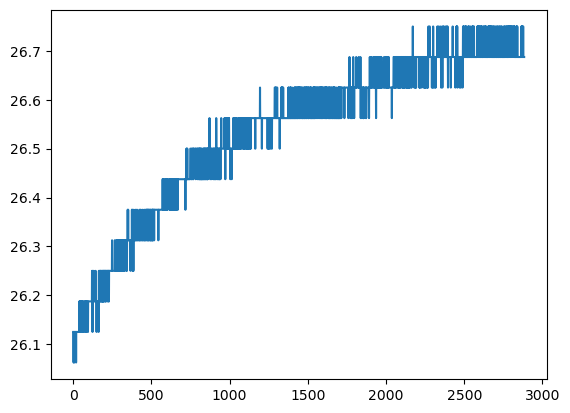

In [20]:
train['temperature'].plot()

In [21]:
train['center_bubbles_px'] *= .003
test_1['center_bubbles_px'] *= .003
test_2['center_bubbles_px'] *= .003
test_3['center_bubbles_px'] *= .003

# features = train[CFG.FEATURES]
features = train.drop(columns=CFG.TARGET)
target = train[CFG.TARGET]

In [22]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['count'] = df.count().values
    sum['skew'] = df.skew().values
    return sum

s = summary(features)
s.style.background_gradient(cmap='Blues')

,dtypes,count,skew
center_bubbles_px,float64,2884,-0.073067
temperature,float64,2884,-0.885925
1,float64,2884,-0.018869
2,float64,2884,0.104093
3,float64,2884,-0.018821
4,float64,2884,0.087367
5,float64,2884,-0.018525
6,float64,2884,0.448735
7,float64,2884,-0.018476
8,float64,2884,0.224677


In [23]:
features = features.drop(columns=list(s.query('skew > 0.5 or skew < -0.5').index))

temp1 = test_1['temperature'].copy()
temp2 = test_2['temperature'].copy()
temp3 = test_3['temperature'].copy()

test_1 = test_1.drop(columns=list(s.query('skew > 0.5 or skew < -0.5').index))
test_2 = test_2.drop(columns=list(s.query('skew > 0.5 or skew < -0.5').index))
test_3 = test_3.drop(columns=list(s.query('skew > 0.5 or skew < -0.5').index))

features['temperature'] = train['temperature']
test_1['temperature'] = temp1
test_2['temperature'] = temp2
test_3['temperature'] = temp3

# Linear Regression for Ct

slope (95%): 0.948115 +/- 0.002754
intercept (95%): 0.033502 +/- 0.002298


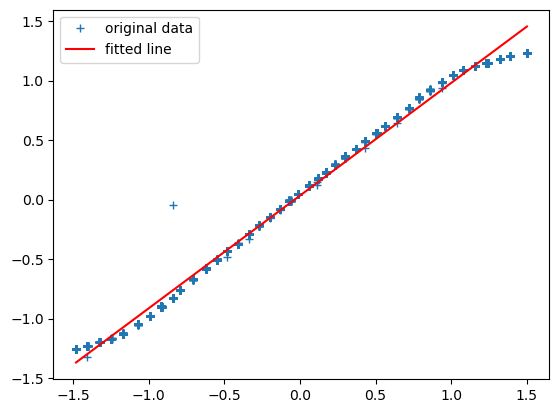

In [24]:
from scipy import stats

res = stats.linregress(target['nivel_y'], features['center_bubbles_px'])

from scipy.stats import t
tinv = lambda p, df: abs(t.ppf(p/2, df))

ts = tinv(0.05, len(features['center_bubbles_px'])-2)
print(f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")

print(f"intercept (95%): {res.intercept:.6f}"
      f" +/- {ts*res.intercept_stderr:.6f}")
# print(f"fitted {res.intercept + res.slope*features['temperature']}")
plt.plot(target['nivel_y'], features['center_bubbles_px'], '+', label='original data')
plt.plot(target['nivel_y'], res.intercept + res.slope*target['nivel_y'], 'r', label='fitted line')
plt.legend()
plt.show()

In [25]:
t_copy = features['center_bubbles_px'].copy()
t_copy -= res.intercept + res.slope*t_copy

In [26]:
np.sqrt(mean_squared_error(target['nivel_y'], t_copy))

0.7942069479097043

In [27]:
dif_l1 = target['nivel_y'] - (t_copy)
dif_l1.mean()

0.0347075219602127

In [28]:
dif_l1.std()

0.7935858074608959

# Multiple Linear Regression

In [29]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2884 entries, 0 to 2883
Columns: 130 entries, center_bubbles_px to temperature
dtypes: float64(130)
memory usage: 2.9 MB


In [30]:
features_mlr = features.copy()
test_1_mlr = test_1.copy()
test_2_mlr = test_2.copy()
test_3_mlr = test_3.copy()

scaler = RobustScaler()
features_mlr = scaler.fit_transform(features_mlr)

test_1_mlr_s = scaler.transform(test_1_mlr.drop(columns=CFG.TARGET))
test_2_mlr_s = scaler.transform(test_2_mlr.drop(columns=CFG.TARGET))
test_3_mlr_s = scaler.transform(test_3_mlr.drop(columns=CFG.TARGET))

In [31]:
reg = LinearRegression().fit(features_mlr, target)

In [32]:
pred_l_1 = reg.predict(test_1_mlr_s)
pred_l_2 = reg.predict(test_2_mlr_s)
pred_l_3 = reg.predict(test_3_mlr_s)

<Axes: >

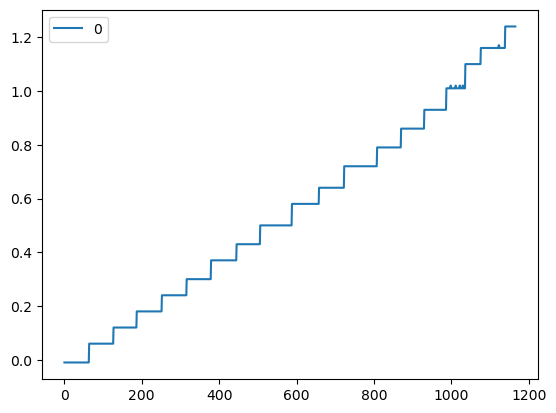

In [33]:
pd.DataFrame(pred_l_2).plot()

<Axes: >

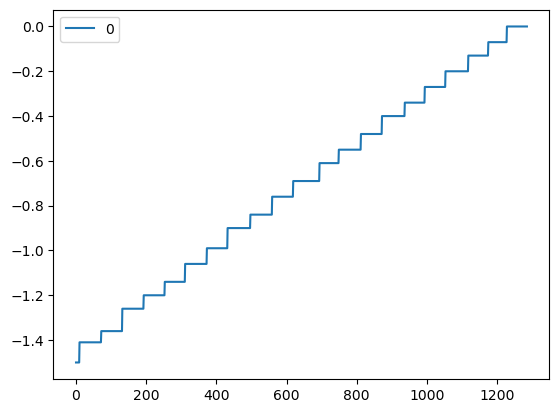

In [34]:
pd.DataFrame(pred_l_3).plot()

In [35]:
print(f"VIM TEST 1: {np.sqrt(mean_squared_error(test_1_mlr[CFG.TARGET], pd.DataFrame(pred_l_1))):.4f}")
print(f"VIM TEST 2: {np.sqrt(mean_squared_error(test_2_mlr[CFG.TARGET], pd.DataFrame(pred_l_2))):.4f}")
print(f"VIM TEST 3: {np.sqrt(mean_squared_error(test_3_mlr[CFG.TARGET], pd.DataFrame(pred_l_3))):.4f}")

VIM TEST 1: 0.0000
VIM TEST 2: 0.0000
VIM TEST 3: 0.0000


In [36]:
dif_l_1 = test_1[CFG.TARGET] - (pred_l_1)
print(dif_l_1.mean())

dif_l_2 = test_2[CFG.TARGET] - (pred_l_2)
print(dif_l_2.mean())

dif_l_3 = test_3[CFG.TARGET] - (pred_l_3)
print(dif_l_3.mean())

nivel_y    2.339111e-12
dtype: float64
nivel_y   -7.354349e-11
dtype: float64
nivel_y   -8.430962e-12
dtype: float64


# Cat

In [643]:
def build_catboost(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 0.01, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', .1, 1., log=True),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 1e-6, 0.01, log=True),
        'boosting_type': 'Plain',
        'bootstrap_type': 'Bayesian',
        'task_type': 'GPU',
        'loss_function':'RMSE',
        'eval_metric' : 'RMSE',
    }

    model = CatBoostRegressor(**params, silent=True, random_state=CFG.RANDOM_STATE)
    cv_data = cv(
        Pool(features, target),
        model.get_params(),
        verbose=False
    )
    return np.min(cv_data['test-RMSE-mean'])

In [644]:
study = optuna.create_study(direction="minimize")
study.optimize(build_catboost, n_trials=10)

[I 2024-12-12 11:44:19,851] A new study created in memory with name: no-name-32e7e172-4cc3-400d-9fd0-0d21757fd62c


Training on fold [0/3]
bestTest = 0.8328810344
bestIteration = 999
Training on fold [1/3]
bestTest = 0.8436236814
bestIteration = 999
Training on fold [2/3]


[I 2024-12-12 11:44:26,765] Trial 0 finished with value: 0.8313497703784892 and parameters: {'learning_rate': 5.076819720507628e-06, 'depth': 1, 'l2_leaf_reg': 0.5216518838026544, 'bagging_temperature': 1.2903799290286127e-05}. Best is trial 0 with value: 0.8313497703784892.


bestTest = 0.8175445953
bestIteration = 999
Training on fold [0/3]
bestTest = 0.8333836107
bestIteration = 999
Training on fold [1/3]
bestTest = 0.844080048
bestIteration = 999
Training on fold [2/3]
bestTest = 0.8181065413
bestIteration = 999


[I 2024-12-12 11:45:14,244] Trial 1 finished with value: 0.8318567333378755 and parameters: {'learning_rate': 3.185820728812864e-06, 'depth': 6, 'l2_leaf_reg': 0.3826656996710987, 'bagging_temperature': 8.525651808962755e-05}. Best is trial 0 with value: 0.8313497703784892.


Training on fold [0/3]
bestTest = 0.01728432519
bestIteration = 999
Training on fold [1/3]
bestTest = 0.02281682623
bestIteration = 999
Training on fold [2/3]


[I 2024-12-12 11:45:29,100] Trial 2 finished with value: 0.018528313381080835 and parameters: {'learning_rate': 0.00604908942156493, 'depth': 2, 'l2_leaf_reg': 0.12356296430008168, 'bagging_temperature': 0.0007631240200911144}. Best is trial 2 with value: 0.018528313381080835.


bestTest = 0.01548378872
bestIteration = 999
Training on fold [0/3]
bestTest = 0.8231683609
bestIteration = 999
Training on fold [1/3]
bestTest = 0.8337223009
bestIteration = 999
Training on fold [2/3]
bestTest = 0.8080442785
bestIteration = 999


[I 2024-12-12 11:46:46,939] Trial 3 finished with value: 0.8216449801143467 and parameters: {'learning_rate': 1.5805153210875853e-05, 'depth': 7, 'l2_leaf_reg': 0.42762186564192917, 'bagging_temperature': 4.156759624898051e-06}. Best is trial 2 with value: 0.018528313381080835.


Training on fold [0/3]
bestTest = 0.6394801644
bestIteration = 999
Training on fold [1/3]
bestTest = 0.6504541661
bestIteration = 999
Training on fold [2/3]


[I 2024-12-12 11:47:06,144] Trial 4 finished with value: 0.6381252019656821 and parameters: {'learning_rate': 0.0002919120902843767, 'depth': 3, 'l2_leaf_reg': 0.9535586924641718, 'bagging_temperature': 8.841799266789782e-06}. Best is trial 2 with value: 0.018528313381080835.


bestTest = 0.6244412754
bestIteration = 999
Training on fold [0/3]
bestTest = 0.4511368668
bestIteration = 999
Training on fold [1/3]
bestTest = 0.4609560667
bestIteration = 999
Training on fold [2/3]
bestTest = 0.438354583
bestIteration = 999


[I 2024-12-12 11:47:25,555] Trial 5 finished with value: 0.4501491721585768 and parameters: {'learning_rate': 0.0006770333026228317, 'depth': 3, 'l2_leaf_reg': 0.9867952624895701, 'bagging_temperature': 2.8542421739655035e-05}. Best is trial 2 with value: 0.018528313381080835.


Training on fold [0/3]
bestTest = 0.6726680156
bestIteration = 999
Training on fold [1/3]
bestTest = 0.6818766411
bestIteration = 999
Training on fold [2/3]
bestTest = 0.6591452105
bestIteration = 999


[I 2024-12-12 11:48:01,847] Trial 6 finished with value: 0.6712299557280827 and parameters: {'learning_rate': 0.00022748433582366756, 'depth': 5, 'l2_leaf_reg': 0.5517021119307507, 'bagging_temperature': 2.1972081895752153e-06}. Best is trial 2 with value: 0.018528313381080835.


Training on fold [0/3]
bestTest = 0.7434552326
bestIteration = 999
Training on fold [1/3]
bestTest = 0.7532551308
bestIteration = 999
Training on fold [2/3]


[I 2024-12-12 11:48:36,606] Trial 7 finished with value: 0.7419370406718793 and parameters: {'learning_rate': 0.00012254721172752408, 'depth': 5, 'l2_leaf_reg': 0.2147192301623272, 'bagging_temperature': 1.6183957351643467e-05}. Best is trial 2 with value: 0.018528313381080835.


bestTest = 0.7291007587
bestIteration = 999
Training on fold [0/3]
bestTest = 0.8332836451
bestIteration = 999
Training on fold [1/3]
bestTest = 0.8439788385
bestIteration = 999
Training on fold [2/3]


[I 2024-12-12 11:49:28,459] Trial 8 finished with value: 0.8317568082967824 and parameters: {'learning_rate': 3.3097539560366646e-06, 'depth': 6, 'l2_leaf_reg': 0.38103214179494366, 'bagging_temperature': 0.0002748080478502898}. Best is trial 2 with value: 0.018528313381080835.


bestTest = 0.8180079413
bestIteration = 999
Training on fold [0/3]
bestTest = 0.2581163393
bestIteration = 999
Training on fold [1/3]
bestTest = 0.2596352367
bestIteration = 999
Training on fold [2/3]


[I 2024-12-12 11:53:33,040] Trial 9 finished with value: 0.25636831492011636 and parameters: {'learning_rate': 0.0012056936895696348, 'depth': 9, 'l2_leaf_reg': 0.1635006213623552, 'bagging_temperature': 2.889107491765926e-06}. Best is trial 2 with value: 0.018528313381080835.


bestTest = 0.2513533687
bestIteration = 999


In [645]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.00604908942156493, 'depth': 2, 'l2_leaf_reg': 0.12356296430008168, 'bagging_temperature': 0.0007631240200911144}
Best RMSE: 0.018528313381080835


In [646]:
rmses = []
preds = []
skf = KFold(n_splits=CFG.N_FOLDS)

for fold, (train_idx, valid_idx) in enumerate(skf.split(features, target)):
    print(f'### Fold {fold+1} Training ###')

    X_train = train.loc[train_idx, [c for c in features.columns if c not in [CFG.TARGET]]]
    y_train = train.loc[train_idx, CFG.TARGET]
    X_valid = train.loc[valid_idx, X_train.columns]
    y_valid = train.loc[valid_idx, CFG.TARGET]



    X_train_pool = Pool(X_train, y_train)
    X_valid_pool = Pool(X_valid, y_valid)


    model = CatBoostRegressor(
        loss_function='RMSE',
        learning_rate=0.00604908942156493,
        iterations=10000,
        depth=2,
        l2_leaf_reg=0.12356296430008168,
        bagging_temperature=0.0007631240200911144,
        boosting_type='Plain', 
        bootstrap_type='Bayesian',
        task_type='GPU',
        eval_metric='RMSE',
        random_seed=CFG.RANDOM_STATE,
        verbose=False
    )

    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=500, early_stopping_rounds=200)

    pred_valid = model.predict(X_valid_pool)
    preds.append(pred_valid)

    rmse = mean_squared_error(y_valid, pred_valid)**.5
    rmses.append(rmse)
    
    del X_train, y_train, X_valid, y_valid
    gc.collect()

    print(f'Fold {fold+1} RMSE: {rmse:.5f}\n')

print(f'\nOverall RMSE: {np.median(rmse):.5f} +/- {np.std(rmse):.5f}')

### Fold 1 Training ###
0:	learn: 0.7853250	test: 1.4766119	best: 1.4766119 (0)	total: 3.99ms	remaining: 39.9s
500:	learn: 0.0781220	test: 0.3615083	best: 0.3615083 (500)	total: 1.44s	remaining: 27.4s
1000:	learn: 0.0150083	test: 0.1583848	best: 0.1583848 (1000)	total: 2.88s	remaining: 25.9s
1500:	learn: 0.0077176	test: 0.1185764	best: 0.1185039 (1498)	total: 4.43s	remaining: 25.1s
2000:	learn: 0.0062126	test: 0.1140987	best: 0.1140987 (2000)	total: 5.87s	remaining: 23.5s
2500:	learn: 0.0056627	test: 0.1109561	best: 0.1109561 (2500)	total: 7.32s	remaining: 22s
3000:	learn: 0.0053593	test: 0.1089363	best: 0.1089363 (3000)	total: 8.99s	remaining: 21s
3500:	learn: 0.0051703	test: 0.1078918	best: 0.1078916 (3497)	total: 11.1s	remaining: 20.7s
4000:	learn: 0.0050315	test: 0.1070304	best: 0.1070304 (4000)	total: 13.2s	remaining: 19.9s
4500:	learn: 0.0049004	test: 0.1064207	best: 0.1064207 (4500)	total: 15.5s	remaining: 18.9s
5000:	learn: 0.0047951	test: 0.1060572	best: 0.1060572 (5000)	total

In [647]:
# model.save_model('model_drift_1')

In [37]:
model = CatBoostRegressor()
model.load_model('model_drift_1')

In [38]:
cat_pred_1 = model.predict(test_1.drop(columns=CFG.TARGET))

In [39]:
cat_pred_2 = model.predict(test_2.drop(columns=CFG.TARGET))

In [40]:
cat_pred_3 = model.predict(test_3.drop(columns=CFG.TARGET))

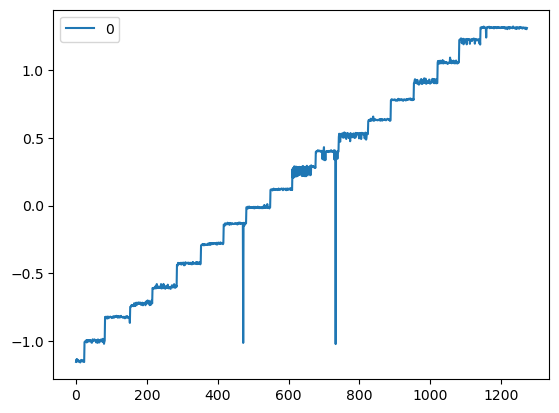

In [41]:
pd.DataFrame(cat_pred_1).plot();

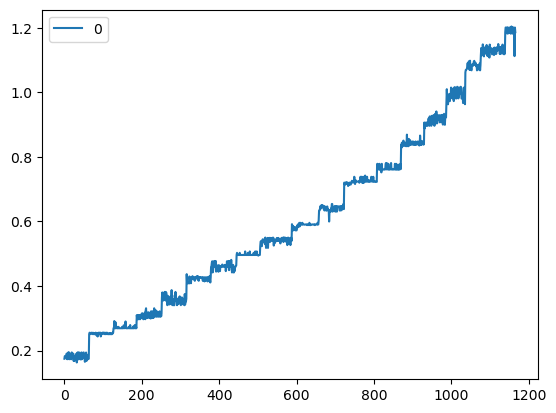

In [42]:
pd.DataFrame(cat_pred_2).plot();

<Axes: >

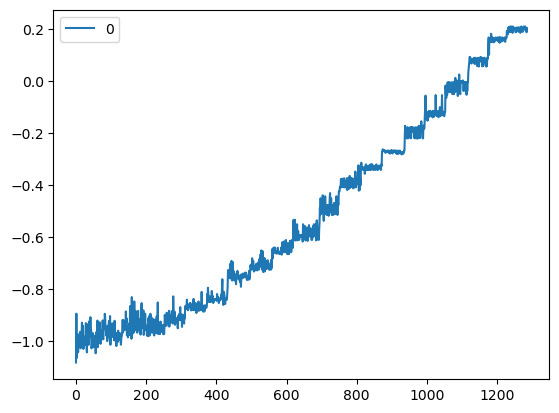

In [43]:
pd.DataFrame(cat_pred_3).plot()

In [44]:
print(f"VIM TEST 1: {np.sqrt(mean_squared_error(test_1[CFG.TARGET], pd.DataFrame(cat_pred_1))):.4f}")
print(f"VIM TEST 2: {np.sqrt(mean_squared_error(test_2[CFG.TARGET], pd.DataFrame(cat_pred_2))):.4f}")
print(f"VIM TEST 3: {np.sqrt(mean_squared_error(test_3[CFG.TARGET], pd.DataFrame(cat_pred_3))):.4f}")

VIM TEST 1: 0.0678
VIM TEST 2: 0.0938
VIM TEST 3: 0.2192


In [63]:
dif_с_1 = float(test_1[CFG.TARGET].mean()) - pd.DataFrame(cat_pred_1).mean()
print(f"Mean error {dif_с_1[0]:.4f}")

dif_с_2 = float(test_2[CFG.TARGET].mean()) - pd.DataFrame(cat_pred_2).mean()
print(f"Mean error {dif_с_2[0]:.4f}")

dif_с_3 = float(test_3[CFG.TARGET].mean()) - pd.DataFrame(cat_pred_3).mean()
print(f"Mean error {dif_с_3[0]:.4f}")

Mean error 0.0079
Mean error -0.0540
Mean error -0.1988


In [46]:
dif_с_1 = float(test_1[CFG.TARGET].std()) - pd.DataFrame(cat_pred_1).std()
print(f"STD error {dif_с_1[0]:.4f}")

dif_с_2 = float(test_2[CFG.TARGET].std()) - pd.DataFrame(cat_pred_2).std()
print(f"STD error {dif_с_2[0]:.4f}")

dif_с_3 = float(test_3[CFG.TARGET].std()) - pd.DataFrame(cat_pred_3).std()
print(f"STD error {dif_с_3[0]:.4f}")

STD error 0.0206
STD error 0.0710
STD error 0.0448


# NN

In [768]:
scaler = RobustScaler()
features = scaler.fit_transform(features)

In [769]:
features_train, features_valid, target_train, target_valid = \
    train_test_split(features, target, train_size=0.75, random_state=CFG.RANDOM_STATE)

In [770]:
test_nn1 = scaler.transform(test_1.drop(columns=CFG.TARGET))
test_nn2 = scaler.transform(test_2.drop(columns=CFG.TARGET))
test_nn3 = scaler.transform(test_3.drop(columns=CFG.TARGET))

In [821]:
def build_neural_network(hp):    
    model = Sequential()
    model.add(layers.Flatten())
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=2, max_value=12, step=1),
                activation=hp.Choice("activation", ["tanh", "relu", "linear"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.15))
    model.add(layers.Dense(1))
    learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mean_squared_error', 
        metrics=[RootMeanSquaredError()]
    )
    return model

In [822]:
build_neural_network(keras_tuner.HyperParameters())

In [823]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_neural_network,
    objective=keras_tuner.Objective('val_loss', 'min'),
    max_trials=20,
    executions_per_trial=3,
    overwrite=True,
)

In [824]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 12, 'step': 1, 'sampling': 'linear'}
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'relu', 'linear'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [825]:
tuner.search(features_train, target_train, epochs=10, validation_data=(features_valid, target_valid))

Trial 20 Complete [00h 00m 06s]
val_loss: 0.011465981913109621

Best val_loss So Far: 0.0020565049489960074
Total elapsed time: 00h 01m 55s


In [826]:
best_NN = build_neural_network(tuner.get_best_hyperparameters()[0])

In [827]:
callback = EarlyStopping(monitor='loss', patience=200)

In [828]:
best_NN.fit(
    features_train,  
    target_train,
    epochs=10000,
    callbacks=[callback]
)

Epoch 1/10000
68/68 [==============================] - 0s 821us/step - loss: 0.1388 - root_mean_squared_error: 0.3726
Epoch 2/10000
68/68 [==============================] - 0s 828us/step - loss: 0.0106 - root_mean_squared_error: 0.1028
Epoch 3/10000
68/68 [==============================] - 0s 843us/step - loss: 0.0053 - root_mean_squared_error: 0.0728
Epoch 4/10000
68/68 [==============================] - 0s 836us/step - loss: 0.0038 - root_mean_squared_error: 0.0613
Epoch 5/10000
68/68 [==============================] - 0s 828us/step - loss: 0.0030 - root_mean_squared_error: 0.0547
Epoch 6/10000
68/68 [==============================] - 0s 836us/step - loss: 0.0023 - root_mean_squared_error: 0.0482
Epoch 7/10000
68/68 [==============================] - 0s 828us/step - loss: 0.0022 - root_mean_squared_error: 0.0468
Epoch 8/10000
68/68 [==============================] - 0s 843us/step - loss: 0.0020 - root_mean_squared_error: 0.0442
Epoch 9/10000
68/68 [==============================] - 0

In [829]:
best_NN.save('NN_best_drift1.keras')

In [830]:
# import keras
# best_NN = keras.models.load_model('NN_model_1_best_multi.keras')

In [831]:
ynew = best_NN.predict(test_nn1)
class_probabilities = np.hstack((1-ynew, ynew))
pred1 = pd.DataFrame(ynew)

ynew = best_NN.predict(test_nn2)
class_probabilities = np.hstack((1-ynew, ynew))
pred2 = pd.DataFrame(ynew)

ynew = best_NN.predict(test_nn3)
class_probabilities = np.hstack((1-ynew, ynew))
pred3 = pd.DataFrame(ynew)

41/41 [==============================] - 0s 625us/step


In [832]:
print(f"VIM TEST 1: {np.sqrt(mean_squared_error(test_1[CFG.TARGET], pred1)):.4f}")
print(f"VIM TEST 2: {np.sqrt(mean_squared_error(test_2[CFG.TARGET], pred2)):.4f}")
print(f"VIM TEST 3: {np.sqrt(mean_squared_error(test_3[CFG.TARGET], pred3)):.4f}")

VIM TEST 1: 0.0509
VIM TEST 2: 31.3718
VIM TEST 3: 55.4770
VIM TEST 2: 31.3718
VIM TEST 3: 55.4770


In [833]:
dif_nn_1 = float(test_1[CFG.TARGET].mean()) - pd.DataFrame(pred1).mean()
print(f"Mean error {dif_nn_1[0]:.4f}")

dif_nn_2 = float(test_2[CFG.TARGET].mean()) - pd.DataFrame(pred2).mean()
print(f"Mean error {dif_nn_2[0]:.4f}")

dif_nn_3 = float(test_3[CFG.TARGET].mean()) - pd.DataFrame(pred3).mean()
print(f"Mean error {dif_nn_3[0]:.4f}")

Mean error 0.0041
Mean error -30.8687
Mean error -54.8948


<Axes: >

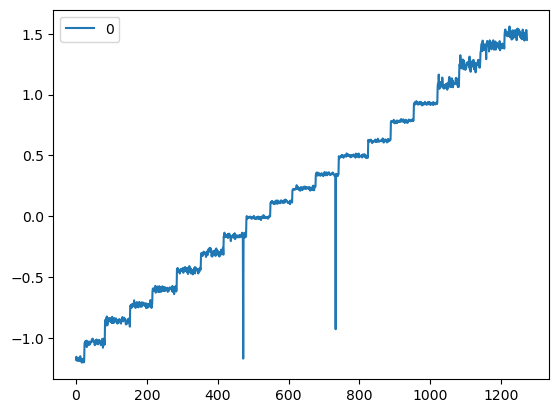

In [834]:
pred1.plot()

<Axes: >

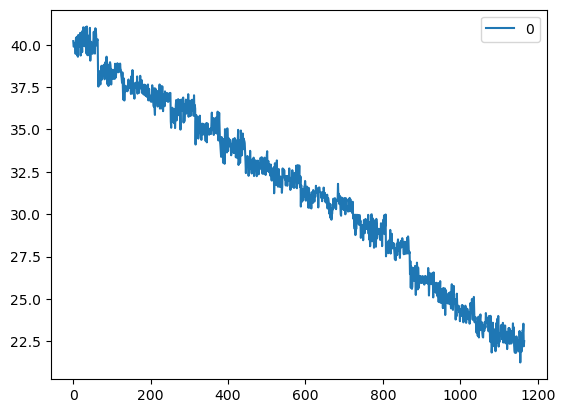

In [835]:
pred2.plot()

<Axes: >

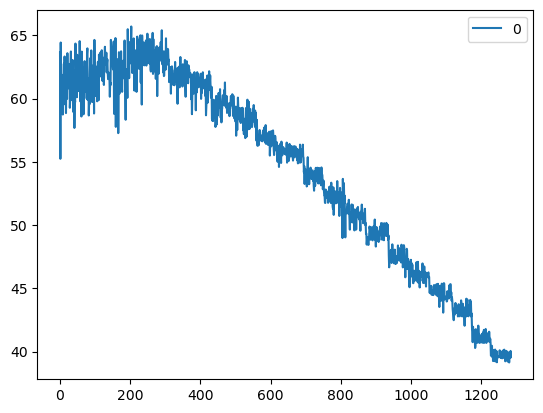

In [836]:
pred3.plot()

In [174]:
# dif_nn = test['nivel_y'] - pred[0]
# dif_nn.mean()

# Graphics

In [710]:
from keras_visualizer import visualizer

settings = {
    'MAX_NEURONS': None,
    'INPUT_DENSE_COLOR': 'teal',
    'HIDDEN_DENSE_COLOR': 'orange',
    'OUTPUT_DENSE_COLOR': 'crimson'
}



visualizer(best_NN, file_name = 'DRIFT', file_format='png', settings=settings)

In [79]:
temp = test_1[CFG.TARGET].copy()
temp2 = test_2[CFG.TARGET].copy()
temp3 = test_3[CFG.TARGET].copy()

In [80]:
temp

,nivel_y
0,-1.17
1,-1.17
2,-1.17
3,-1.17
4,-1.17
...,...
1269,1.51
1270,1.51
1271,1.51
1272,1.51


In [81]:
temp['dif'] = temp['nivel_y'] - cat_pred_1
temp2['dif2'] = temp2['nivel_y'] - cat_pred_2
temp3['dif3'] = temp3['nivel_y'] - cat_pred_3

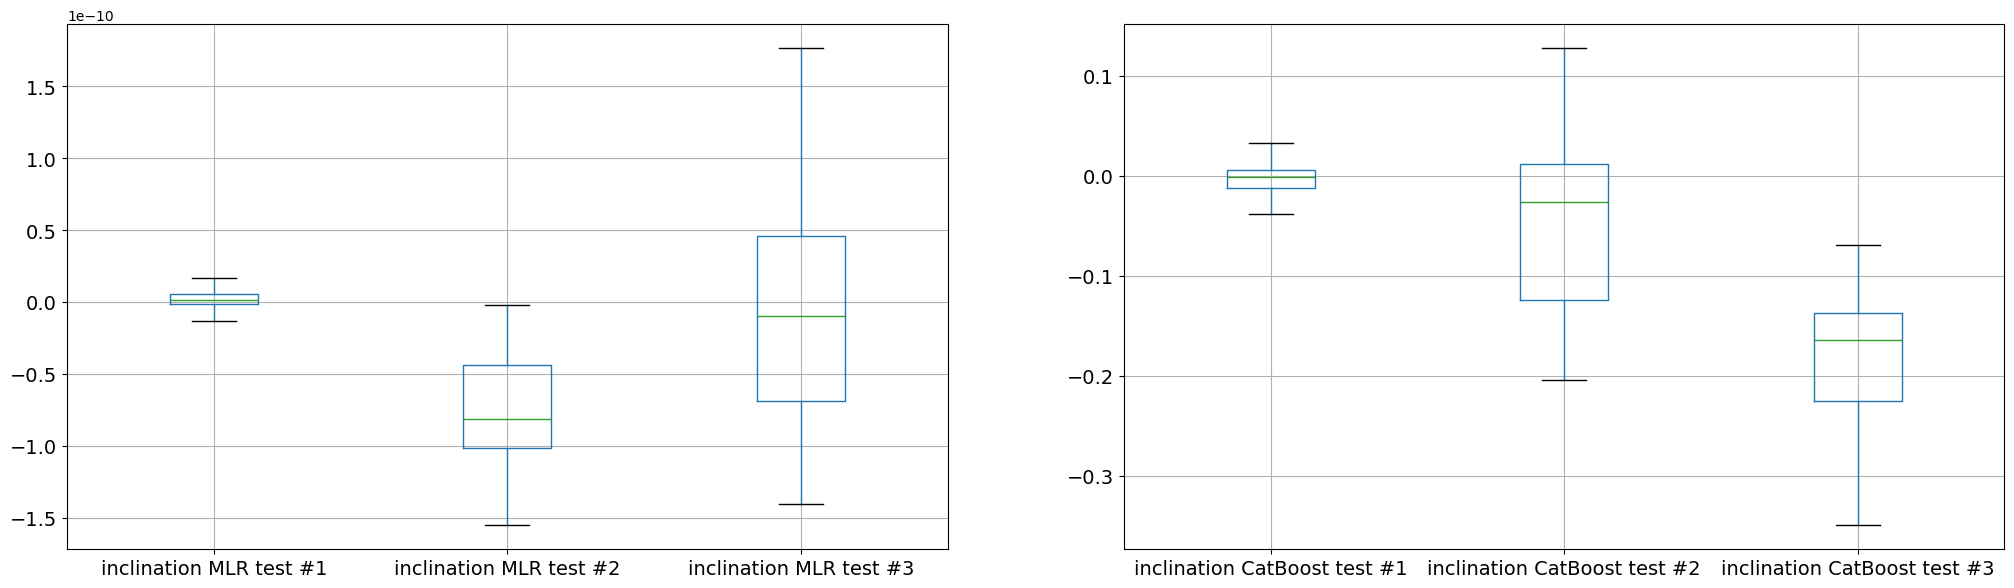

In [90]:
# LR = pd.DataFrame({'inclination LR' : dif_l1})
MLR = pd.DataFrame({'inclination MLR test #1' : dif_l_1['nivel_y'],
                    'inclination MLR test #2' : dif_l_2['nivel_y'],
                    'inclination MLR test #3' : dif_l_3['nivel_y']})

CB = pd.DataFrame({'inclination CatBoost test #1' : temp['dif'],
                   'inclination CatBoost test #2' : temp2['dif2'], 
                   'inclination CatBoost test #3' : temp3['dif3']})
# NN = pd.DataFrame({'inclination NN' : dif_,})



fig = plt.figure(figsize=(25,15))
ax2 =fig.add_subplot(2,2,1)
MLR.boxplot(ax = ax2,showfliers=False, fontsize=14)
ax3 =fig.add_subplot(2,2,2)
CB.boxplot(ax = ax3,showfliers=False, fontsize=14)
plt.show()

In [51]:
MLR

,inclination MLR test #1,inclination MLR test #2,inclination MLR test #3
0,-2.030376e-12,-1.098022e-10,8.080292e-11
1,-1.973532e-12,-1.249225e-10,1.181775e-10
2,-5.242029e-12,-1.100011e-10,6.173195e-11
3,6.155076e-12,-9.564815e-11,1.126921e-10
4,5.018208e-12,-1.245246e-10,8.728307e-11
...,...,...,...
1281,NaN,NaN,-1.252545e-10
1282,NaN,NaN,-1.186038e-10
1283,NaN,NaN,-1.054161e-10
1284,NaN,NaN,-8.967049e-11
